# Wasserstein GAN in Pytorch

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/roebius/pj/p3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [3]:
bs,sz,nz = 64,64,100

Pytorch has the handy [torch-vision](https://github.com/pytorch/vision) library which makes handling images fast and easy.

In [4]:
# - uncomment this cell if CIFAR10 dataset is used insted of lsun
PATH = 'data/cifar10/'
data = datasets.CIFAR10(root=PATH, download=True,
   transform=transforms.Compose([
       transforms.Scale(sz),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)

Files already downloaded and verified


In [5]:
# - uncomment this cell if lsun dataset is used insted of CIFAR10
# PATH = 'data/lsun'
# data = datasets.LSUN(db_path=PATH, classes=['bedroom_train'],
#     transform=transforms.Compose([
#         transforms.Scale(sz),
#         transforms.CenterCrop(sz),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ]))

Even parallel processing is handling automatically by torch-vision.

In [6]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader); n

782

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [7]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [8]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [9]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
netG = DCGAN_G(sz, nz, 3, 64, 1, 1).cuda()
netG.apply(weights_init);

In [11]:
netD = DCGAN_D(sz, 3, 64, 1, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [12]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [13]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [14]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [15]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [16]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [17]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [18]:
from tqdm import tqdm

def train(niter, first=True):
    gen_iterations = 0
    for epoch in tqdm(range(niter)):
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1

        if epoch % 2 == 0:
            print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
                epoch, niter, gen_iterations, n,
                errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

In [19]:
%time train(3, True)

 33%|███▎      | 1/3 [03:48<07:36, 228.46s/it]

[0/3][8/782] Loss_D: -1.548677 Loss_G: 0.759640 Loss_D_real: -0.804204 Loss_D_fake 0.744473


100%|██████████| 3/3 [11:17<00:00, 226.51s/it]

[2/3][24/782] Loss_D: -1.567038 Loss_G: 0.762890 Loss_D_real: -0.818875 Loss_D_fake 0.748163
CPU times: user 9min 47s, sys: 1min 31s, total: 11min 19s
Wall time: 11min 17s


## View

In [20]:
fake = netG(fixed_noise).data.cpu()

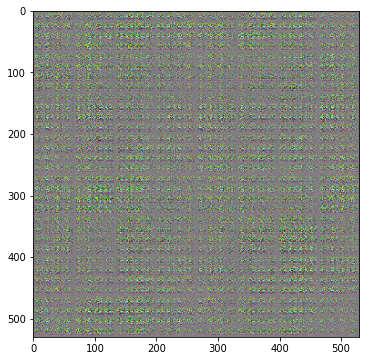

In [21]:
show(vutils.make_grid(fake))

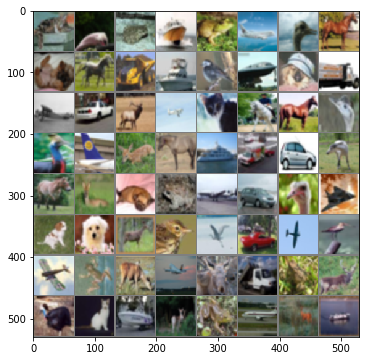

In [22]:
show(vutils.make_grid(iter(dataloader).next()[0]))

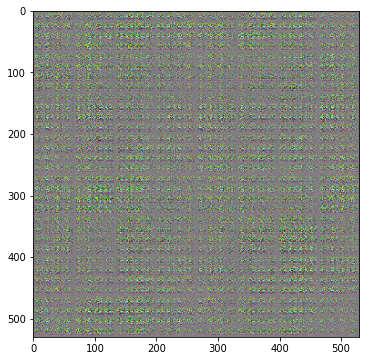

In [23]:
show(vutils.make_grid(fake))

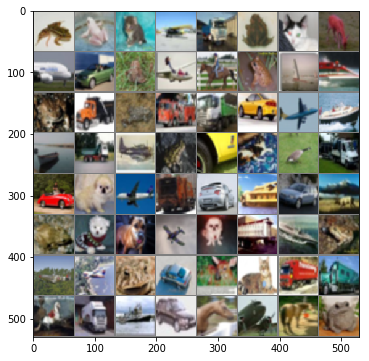

In [24]:
show(vutils.make_grid(iter(dataloader).next()[0]))